In [1]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import polars as pl
import numpy as np
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
from pygam import LinearGAM, s
from model_script.script_XGBoost_model_polars import DataCleaner, FeatureCreator, AnomalyFilter, WeightedPOICountsTransformer, data_loader, build_xgboost_model,save_model,plot_train_test_predictions

In [2]:
YEARS =["2019","2020", "2021", "2022", "2023","2024"]
PREPROCESSED_FILE = "data_processed/data_dvf_preprocessed_test_explicabilite_IDF.csv"
BATCH_SIZE = 100_000
dep = ["75", "77", "78", "91", "92", "93", "94", "95"]

print("Starting preprocessing by year...")
# Charger la grille pour le pipeline
df_grid = pl.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')

# Définir le pipeline de preprocessing
pipeline_preprocess = Pipeline(steps=[
    ("cleaner", DataCleaner(nombre_lots_max=5, cutoff_valeur_fonciere_min=0.75e5, min_surface=15)),
    ("feature_creator", FeatureCreator(cutoff_prix_m2_min=3e3,cutoff_prix_m2_max=18e3)),
    ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
    ("anomaly_filter", AnomalyFilter(contamination=0.1, target_elimination=True, prix_m2= True)),
    # ('weighted_poi', WeightedPOICountsTransformer(n_neighbors=4)),
])

pipeline_preprocess.set_params(weighted_poi__df_grid=df_grid)

with open(PREPROCESSED_FILE, "w") as f:
    pass

# === 1. Charger et prétraiter chaque année séparément ===
for year in YEARS:
    print(f"Processing year {year}...")

    # Charger les données de l'année en cours
    df_year = data_loader('data_dvf', annees=[year],departements=dep)
    print(f"Data loaded for {year}: {df_year.shape[0]} rows")

    # Appliquer le préprocessing
    df_processed = pipeline_preprocess.fit_transform(df_year)
    df_processed.drop_nulls()
    print(f"Data processed for {year}: {df_processed.shape[0]} rows")

    # Sauvegarder les données prétraitées en ajoutant au CSV
    with open(PREPROCESSED_FILE, mode="a") as f:
        df_processed.write_csv(f,include_header=True)

print("All years processed and saved!")

Starting preprocessing by year...
Processing year 2019...
Data loaded for 2019: 274317 rows
Shape before filtering: (274317, 15)
Shape after filtering: (167664, 15)
Data processed for 2019: 56350 rows
Processing year 2020...
Data loaded for 2020: 437750 rows
Shape before filtering: (437750, 15)
Shape after filtering: (256146, 15)
Data processed for 2020: 93476 rows
Processing year 2021...
Data loaded for 2021: 544775 rows
Shape before filtering: (544775, 15)
Shape after filtering: (345787, 15)
Data processed for 2021: 106338 rows
Processing year 2022...
Data loaded for 2022: 560673 rows
Shape before filtering: (560673, 15)
Shape after filtering: (356939, 15)
Data processed for 2022: 107168 rows
Processing year 2023...
Data loaded for 2023: 450368 rows
Shape before filtering: (450368, 15)
Shape after filtering: (271343, 15)
Data processed for 2023: 77739 rows
Processing year 2024...
Data loaded for 2024: 185731 rows
Shape before filtering: (185731, 15)
Shape after filtering: (115689, 15

In [3]:
df_lazy = pl.scan_csv(
            PREPROCESSED_FILE,
            has_header = True,
            schema_overrides={
                'surface_reelle_bati': pl.Float32,
                'type_local': pl.Utf8,  # Optimisation mémoire
                'year': pl.Int32,  # Réduction mémoire
                'sin_month': pl.Float32,
                'cos_month': pl.Float32,
                'nombre_lots': pl.Float32,
                'total_surface_carrez': pl.Float32,
                'lot1_surface_carrez': pl.Float32,
                'lot2_surface_carrez': pl.Float32,
                'lot3_surface_carrez': pl.Float32,
                'lot4_surface_carrez': pl.Float32,
                'lot5_surface_carrez': pl.Float32,
                'nombre_pieces_principales': pl.Float32,
                'surface_terrain': pl.Float32,
                'longitude': pl.Float32,
                'latitude': pl.Float32,
                'prix_m2': pl.Float64,
                'densite_weighted': pl.Float32,
                'transport_pois_weighted': pl.Float32,
                'education_pois_weighted': pl.Float32,
                'health_pois_weighted': pl.Float32,
                'food_pois_weighted': pl.Float32,
                'shopping_pois_weighted': pl.Float32,
                'park_pois_weighted': pl.Float32,
                'entertainment_pois_weighted': pl.Float32,
                'cultural_pois_weighted': pl.Float32
            },
            ignore_errors = True
        ).drop_nulls()


# === 3. Séparation Train / Test (Lazy) ===
df = df_lazy.collect().sample(fraction=1.0,shuffle=True) # Convertit en DataFrame
df = df.with_columns(pl.lit(np.random.rand(len(df))).alias("split"))  # Ajoute une colonne random
df_lazy = df.lazy()  # Reconvertit en LazyFrame# Ajoute une colonne random
df_train = df_lazy.filter(pl.col("split") < 0.8).drop("split")  # 80% pour l'entraînement
df_test = df_lazy.filter(pl.col("split") >= 0.8).drop("split")  # 20% pour le test

df_train_features = df_train.drop("prix_m2")
df_train_target = df_train.select("prix_m2")
print(df_train_features.collect().shape)

df_test_features = df_test.drop("prix_m2")
df_test_target = df_test.select("prix_m2")
print(df_test_features.collect().shape)


(376900, 25)
(94721, 25)


In [4]:
# === 1. Préparation des données ===
# Caractéristiques pour le modèle physique
physical_features = ['surface_reelle_bati', 'type_local', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']

# Caractéristiques pour le modèle localisation
contextual_features = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# === 2. Pipelines d'encodage ===
categorical_columns_physical = ['type_local']
numerical_columns_physical = ['surface_reelle_bati', 'nombre_pieces_principales','nombre_lots','total_surface_carrez',
                     'lot1_surface_carrez', 'lot2_surface_carrez','lot3_surface_carrez', 'lot4_surface_carrez',
                     'lot5_surface_carrez','surface_terrain']
numerical_columns_contextual = ['year', 'sin_month', 'cos_month','longitude', 'latitude',
    'densite_weighted', 'transport_pois_weighted', 'education_pois_weighted',
    'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
    'park_pois_weighted', 'entertainment_pois_weighted', 'cultural_pois_weighted']

# Catégories uniques pour l'encodage OneHot
unique_categories = [df_lazy.select(col).drop_nulls().unique().collect().to_series().to_list()
                      for col in categorical_columns_physical]

# Pipeline pour les caractéristiques physiques
physical_pipeline = ColumnTransformer([
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
    ]), categorical_columns_physical),
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_physical)
])

# Pipeline pour les caractéristiques de localisation
contextual_pipeline = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', RobustScaler())
    ]), numerical_columns_contextual)
])

# === 3. Paramètres des modèles ===
# params_physical = {
#     "objective": "reg:squarederror",
#     "learning_rate": 0.5,
#     "max_depth": 8,
#     "n_estimators" : 200,
#     "n_jobs": 2,
#     "subsample": 0.8,
#     "gamma": 0.1,
#     "min_child_weight": 10,
#     "lambda": 1,
#     "alpha": 0.5
# }
# Pour les modèles non-GAM (exemple que vous avez donné) :
params_physical = {
    "alpha": 0.5,
    "l1_ratio": 0.5,
    "max_iter": 1000,
    "tol": 1e-4,
    "fit_intercept": False
}
params_contextual = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 8,
    "n_estimators" : 200,
    "n_jobs": 2,
    "subsample": 0.9,
    "gamma": 0.2,
    "min_child_weight": 5,
    "lambda": 1,
    "alpha": 0.3
}

# Pour utiliser des modèles GAM, on définit :
params_physical_gam = {
    "lam": 0.5,
    "n_splines": 10,
    "max_iter": 100,
    "n_features": 10
}
params_contextual_gam = {
    "lam": 0.3,
    "n_splines": 10,
    "max_iter": 100,
    "n_features": 5
}


In [5]:
# # === Custom Estimator to combine predictions ===
# class CombinedModel(BaseEstimator, RegressorMixin):
#     def __init__(self, physical_model, contextual_model):
#         self.physical_model = physical_model
#         self.contextual_model = contextual_model

#     def fit(self, X, y):
#         X_physical = X[physical_features]
#         X_contextual = X[contextual_features]

#         self.physical_model.fit(X_physical, y)
#         self.contextual_model.fit(X_contextual, y)
#         return self

#     def predict(self, X):
#         X_physical = X[physical_features]
#         X_contextual = X[contextual_features]

#         pred_physical = self.physical_model.predict(X_physical)
#         pred_contextual = self.contextual_model.predict(X_contextual)

#         return pred_physical + pred_contextual


In [6]:
# # Pipeline for physical features
# physical_pipeline = ColumnTransformer([
#     ('onehot', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', categories=unique_categories))
#     ]), categorical_columns_physical),
#     ('numeric', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('scaler', RobustScaler())
#     ]), numerical_columns_physical)
# ])

# # Pipeline for contextual features
# contextual_pipeline = ColumnTransformer([
#     ('numeric', Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('scaler', RobustScaler())
#     ]), numerical_columns_contextual)
# ])

# # Physical model pipeline
# physical_model_pipeline = Pipeline([
#     ('preprocessing', physical_pipeline),
#     ('model', xgb.XGBRegressor(**params_physical))
# ])

# # Contextual model pipeline
# contextual_model_pipeline = Pipeline([
#     ('preprocessing', contextual_pipeline),
#     ('model', xgb.XGBRegressor(**params_contextual))
# ])

# # Combined model pipeline
# combined_pipeline = Pipeline([
#     ('combined_model', CombinedModel(
#         physical_model=physical_model_pipeline,
#         contextual_model=contextual_model_pipeline
#     ))
# ])

In [13]:
class GAMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, term, max_iter=100, lam=0.5):
        self.term = term
        self.max_iter = max_iter
        self.lam = lam
        self.gam_ = None  # Ce sera l'instance de LinearGAM une fois ajustée

    def fit(self, X, y):
        self.gam_ = LinearGAM(self.term, max_iter=self.max_iter, lam=self.lam).fit(X, y)
        return self

    def predict(self, X):
        return self.gam_.predict(X)

    def get_params(self, deep=True):
        return {"term": self.term, "max_iter": self.max_iter, "lam": self.lam}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

class CombinedXGBModel(BaseEstimator, RegressorMixin):
    def __init__(self, physical_params, contextual_params, physical_weight=0.5, save=False, stacking=False, gam=False):
        """
        physical_params et contextual_params sont des dictionnaires.
        Pour utiliser les GAM, ils doivent contenir la clé 'n_features' indiquant le nombre de features.
        """
        self.physical_params = physical_params
        self.contextual_params = contextual_params
        self.physical_weight = physical_weight
        self.contextual_weight = 1 - physical_weight
        self.save = save
        self.stacking = stacking
        self.gam = gam
        self._build_models()

    def _build_models(self):
        if self.gam:
            # Récupérer le nombre de features pour chaque groupe
            n_phys = self.physical_params.get('n_features')
            n_ctx = self.contextual_params.get('n_features')
            if n_phys is None or n_ctx is None:
                raise ValueError("Pour utiliser GAM, spécifiez 'n_features' dans physical_params et contextual_params.")
            # Création des termes pour le GAM physique
            terms_phys = s(0)
            for i in range(1, n_phys):
                terms_phys += s(i)
            # On utilise GAMRegressor pour encapsuler le LinearGAM
            self.physical_model = GAMRegressor(
                term=terms_phys,
                max_iter=self.physical_params.get('max_iter', 100),
                lam=self.physical_params.get('lam', 0.5)
            )
            # Création des termes pour le GAM contextuel
            terms_ctx = s(0)
            for i in range(1, n_ctx):
                terms_ctx += s(i)
            self.contextual_model = GAMRegressor(
                term=terms_ctx,
                max_iter=self.contextual_params.get('max_iter', 100),
                lam=self.contextual_params.get('lam', 0.3)
            )
            if self.stacking:
                # Pour le stacking, le final_estimator reçoit 2 features (les prédictions des deux GAM de base)
                self.stacking_model = StackingRegressor(
                    estimators=[('physical', self.physical_model), ('contextual', self.contextual_model)],
                    final_estimator=ElasticNet(fit_intercept=False),
                    passthrough=True
                )
        else:
            # Utilisation des modèles standards
            self.physical_model = ElasticNet(**self.physical_params)
            self.contextual_model = xgb.XGBRegressor(**self.contextual_params)
            if self.stacking:
                self.stacking_model = StackingRegressor(
                    estimators=[('physical', self.physical_model), ('contextual', self.contextual_model)],
                    final_estimator=ElasticNet(fit_intercept=False),
                    passthrough=True
                )

    def fit(self, X, y):
        if isinstance(X, CustomTupleWrapper):
            X_physical, X_contextual = X.X_physical, X.X_contextual
        elif isinstance(X, (list, np.ndarray)):
            sample = X[0]
            if isinstance(sample, (tuple, list)) and len(sample) == 2:
                X_physical, X_contextual = map(np.array, zip(*X))
            else:
                raise ValueError("X n'est pas au format attendu (liste de tuples à 2 éléments).")
        else:
            X_physical, X_contextual = X

        if self.stacking:
            X_combined = np.hstack((X_physical, X_contextual))
            self.stacking_model.fit(X_combined, y)
        else:
            self.physical_model.fit(X_physical, y)
            self.contextual_model.fit(X_contextual, y)
        return self

    def predict(self, X):
        if isinstance(X, CustomTupleWrapper):
            X_physical, X_contextual = X.X_physical, X.X_contextual
        elif isinstance(X, (list, np.ndarray)):
            sample = X[0]
            if isinstance(sample, (tuple, list)) and len(sample) == 2:
                X_physical, X_contextual = map(np.array, zip(*X))
            else:
                raise ValueError("X n'est pas au format attendu (liste de tuples à 2 éléments).")
        else:
            X_physical, X_contextual = X

        if self.stacking:
            X_combined = np.hstack((X_physical, X_contextual))
            return self.stacking_model.predict(X_combined)
        else:
            pred_physical = self.physical_model.predict(X_physical)
            pred_contextual = self.contextual_model.predict(X_contextual)
            combined_preds = (self.physical_weight * pred_physical + self.contextual_weight * pred_contextual)
            return combined_preds

    def save_models(self, directory='saved_models'):
        if not os.path.exists(directory):
            os.makedirs(directory)
        if self.stacking:
            joblib.dump(self.stacking_model, os.path.join(directory, 'stacking_model.pkl'))
        else:
            joblib.dump(self.physical_model, os.path.join(directory, 'physical_model.pkl'))
            joblib.dump(self.contextual_model, os.path.join(directory, 'contextual_model.pkl'))

    def load_models(self, directory='saved_models'):
        if self.stacking:
            self.stacking_model = joblib.load(os.path.join(directory, 'stacking_model.pkl'))
        else:
            self.physical_model = joblib.load(os.path.join(directory, 'physical_model.pkl'))
            self.contextual_model = joblib.load(os.path.join(directory, 'contextual_model.pkl'))

    def get_params(self, deep=True):
        params = {
            'physical_params': self.physical_params,
            'contextual_params': self.contextual_params,
            'physical_weight': self.physical_weight,
            'save': self.save,
            'stacking': self.stacking,
            'gam': self.gam
        }
        if deep:
            for key, val in self.physical_params.items():
                params[f'physical_params__{key}'] = val
            for key, val in self.contextual_params.items():
                params[f'contextual_params__{key}'] = val
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if key.startswith("physical_params__"):
                subkey = key.split("__", 1)[1]
                self.physical_params[subkey] = value
            elif key.startswith("contextual_params__"):
                subkey = key.split("__", 1)[1]
                self.contextual_params[subkey] = value
            else:
                setattr(self, key, value)
        self._build_models()
        return self

class CustomGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, **kwargs):
        super().__init__(estimator, param_grid, **kwargs)

    def fit(self, X, y=None, **fit_params):
        # Si X est un tuple de matrices, on ajuste la validation de GridSearchCV
        if isinstance(X, tuple):
            X = CustomTupleWrapper(X)  # Enveloppe le tuple pour éviter l'erreur de validation
        else:
            X = self._split_features(X)

        return super().fit(X, y, **fit_params)

    def predict(self, X):
        if isinstance(X, tuple):
            X = CustomTupleWrapper(X)
        else:
            X = self._split_features(X)

        return super().predict(X)

    def _split_features(self, X):
        X_physical = X[:, :X.shape[1] // 2]
        X_contextual = X[:, X.shape[1] // 2:]
        return CustomTupleWrapper((X_physical, X_contextual))

class CustomTupleWrapper:
    """Encapsule un tuple (X_physical, X_contextual) et se comporte comme une séquence d’échantillons.
       Pour chaque index i, __getitem__(i) retourne (X_physical[i], X_contextual[i])."""
    def __init__(self, X_tuple):
        self.X_physical, self.X_contextual = X_tuple

    def __getitem__(self, index):
        # Si index est un entier, on retourne un tuple pour cet échantillon
        # Si c'est une tranche (slice), on retourne une nouvelle instance du wrapper avec les tranches correspondantes
        if isinstance(index, slice):
            return CustomTupleWrapper((self.X_physical[index], self.X_contextual[index]))
        else:
            return (self.X_physical[index], self.X_contextual[index])

    def __len__(self):
        return len(self.X_physical)

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]


In [14]:
def train_combined_model(df_features, df_target,params_physical, params_contextual, save=False, stacking = False, gam = False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)
    y_train = df_target.collect().to_numpy().ravel()

    # Entraînement du modèle combiné
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual, stacking=stacking, gam = gam)
    combined_model.fit(X_combined, y_train)

    if save:
        combined_model.save_models()  # Sauvegarde des modèles

    return combined_model



# === 6. Prédiction combinée ===
def combined_prediction(model, df_features):
    X_physical = physical_pipeline.transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)  # Créer le tuple pour les prédictions
    return model.predict(X_combined)


def grid_search_combined_model(df_features, df_target,params_physical, params_contextual,stacking = False, gam = False, save=False):
    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())

    # Combiner les deux matrices en un seul tuple
    X_combined = (X_physical, X_contextual)

    y_train = df_target.collect().to_numpy().ravel()

    # Définir le modèle combiné avec les hyperparamètres
    combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual, stacking= stacking, gam=gam)

    # Paramètres à tester dans GridSearch
    if gam:
        param_grid = {
        # 'physical_weight': [0.1, 0.3, 0.5, 0.7, 0.9],
        'physical_params__n_splines': [10, 20, 30],           # Équivalent à n_estimators
        'physical_params__lam': [0.1, 1, 10],                 # Contrôle la régularisation, équivalent à learning_rate
        'physical_params__spline_order': [2, 3],              # Degré des splines, comparable à max_depth

        'contextual_params__n_splines': [10, 20, 30],
        'contextual_params__lam': [0.1, 1, 10],
        'contextual_params__spline_order': [2, 3]
    }
    else:
        param_grid = {
        'physical_weight': [0.1, 0.3, 0.5, 0.7, 0.9],
        'physical_params__n_estimators': [100, 200],
        'physical_params__max_depth': [6, 8, 10],
        'physical_params__learning_rate': [0.1, 0.3, 0.5],
        'contextual_params__n_estimators': [100, 200],
        'contextual_params__max_depth': [4, 6, 8],
        'contextual_params__learning_rate': [0.1, 0.3, 0.5]
        }


    # Utiliser la version personnalisée de GridSearchCV
    grid_search = CustomGridSearchCV(estimator=combined_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

    # Ajustement du modèle
    grid_search.fit(X_combined, y_train)

    # Meilleur modèle et meilleurs paramètres
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Sauvegarder le meilleur modèle
    if save:
        best_model.save_models()  # Sauvegarde des modèles

    return best_model, best_params


In [15]:
combined_model = CombinedXGBModel(physical_params=params_physical, contextual_params=params_contextual)
combined_model.get_params

<bound method CombinedXGBModel.get_params of CombinedXGBModel(contextual_params={'alpha': 0.3, 'gamma': 0.2, 'lambda': 1,
                                    'learning_rate': 0.1, 'max_depth': 8,
                                    'min_child_weight': 5, 'n_estimators': 200,
                                    'n_jobs': 2,
                                    'objective': 'reg:squarederror',
                                    'subsample': 0.9},
                 physical_params={'alpha': 0.5, 'fit_intercept': True,
                                  'l1_ratio': 0.5, 'max_iter': 1000,
                                  'tol': 0.0001})>

In [16]:
# best_model, best_params = grid_search_combined_model(df_train_features, df_train_target,params_contextual=params_contextual_gam,params_physical=params_physical_gam,stacking=True, gam=True)
# y_pred_test = combined_prediction(best_model, df_test_features)

In [17]:
# print(best_params)
# y_test = df_test_target.collect().to_numpy().ravel()
# dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# # Tri des données
# bins = np.arange(min(y_test), max(y_test) + dx, dx)
# bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
# mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
#                     for i in range(len(bins)-1)]
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred_test, alpha=0.6)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
# plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
#         label="Moyenne par intervalle")
# plt.title("Prédictions vs Valeurs Réelles")
# plt.xlabel("Valeurs Réelles")
# plt.ylabel("Prédictions")

# plt.xlim(0.75*min(y_test),1.1*max(y_test))
# plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
# plt.tight_layout()

In [18]:
params_physical = {
    "alpha": 0.5,
    "l1_ratio": 0.5,
    "max_iter": 1000,
    "tol": 1e-4,
    "fit_intercept": True
}
params_contextual = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 8,
    "n_estimators" : 200,
    "n_jobs": 2,
    "subsample": 0.9,
    "gamma": 0.2,
    "min_child_weight": 5,
    "lambda": 1,
    "alpha": 0.3
}

# Pour utiliser des modèles GAM, on définit :
params_physical_gam = {
    "lam": 0.1,
    "n_splines": 10,
    "max_iter": 1000,
    "spline_order":2,
    "n_features": 10
}
params_contextual_gam = {
    "lam": 0.1,
    "n_splines": 10,
    "spline_order":5,
    "max_iter": 1000,
    "n_features": 10
}
combined_model = train_combined_model(df_train_features, df_train_target,params_physical, params_contextual, stacking=True, gam = False)


In [19]:
y_pred_test = combined_prediction(combined_model, df_test_features)

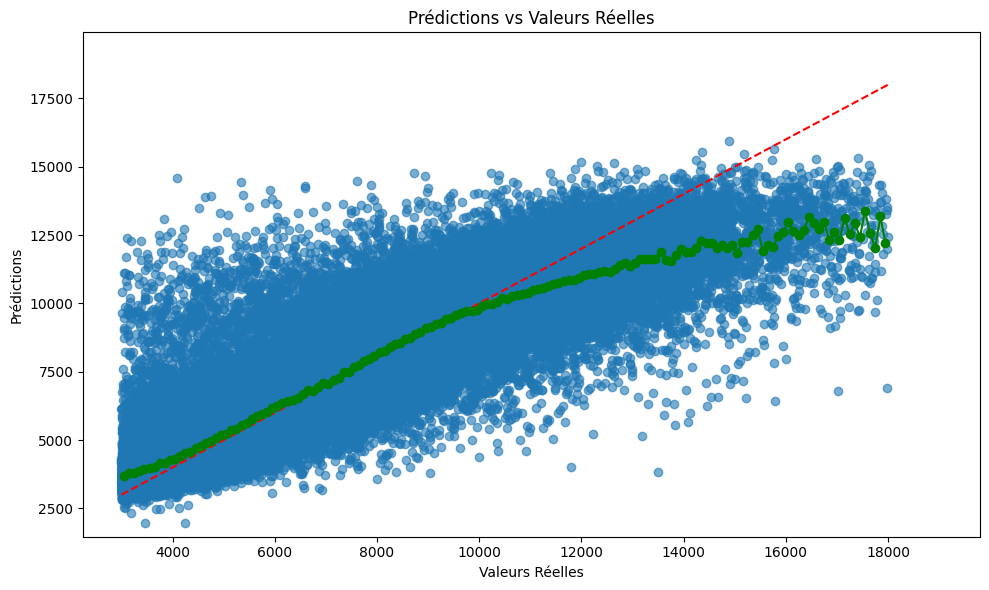

In [20]:
y_test = df_test_target.collect().to_numpy().ravel()
dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# Tri des données
bins = np.arange(min(y_test), max(y_test) + dx, dx)
bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
                    for i in range(len(bins)-1)]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
        label="Moyenne par intervalle")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")

plt.xlim(0.75*min(y_test),1.1*max(y_test))
plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
plt.tight_layout()

In [21]:
def predict_wrapper(X, len_physical=0):
    """
    Cette fonction reçoit X sous forme d'un array 2D combiné.
    Elle sépare les features en deux parties :
      - Les n_physical premières colonnes correspondent à X_physical.
      - Le reste correspond à X_contextual.
    Puis, elle appelle combined_model.predict() en passant un tuple.
    """
    n_physical = len_physical  # Nombre de colonnes pour X_physical
    X_physical = X[:, :n_physical]
    X_contextual = X[:, n_physical:]
    return combined_model.predict((X_physical, X_contextual))


def compute_shap_impact(model, X, sample_size = None):
    """
    Calcule l'impact des modèles sur le méta-modèle via SHAP.

    Parameters:
    - model: Instance de CombinedXGBModel (dont le stacking est activé)
    - X: Données d'entrée sous forme de LazyFrame Polars

    Returns:
    - impact_dict: Dictionnaire des impacts en pourcentage des modèles.
    """
    if not model.stacking:
        raise ValueError("Le calcul SHAP est uniquement applicable lorsque le stacking est activé.")

    # Transformation des données via les pipelines
    X_physical = physical_pipeline.fit_transform(X.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(X.select(contextual_features).collect())
    len_physical = X_physical.shape[1]

    # Combinaison des données sous forme d'un array 2D (par concaténation horizontale)
    X_combined = np.hstack((X_physical, X_contextual))
    if sample_size and sample_size < X_combined.shape[0]:
        indices = np.random.choice(X_combined.shape[0], size=sample_size, replace=False)
        X_sample = X_combined[indices]
    else:
        X_sample = X_combined
    # On définit une fonction callable pour SHAP qui prend en compte le découpage du tableau
    wrapped_predict = lambda X: predict_wrapper(X, len_physical)

    # On crée l'explainer en passant la fonction wrapped_predict et le background (ici X_combined)
    explainer = shap.Explainer(wrapped_predict, X_sample)
    shap_values = explainer(X_sample)

    # Calcul de l'impact moyen par feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Séparation des impacts pour les features physiques et contextuelles
    n_physical_features = len_physical
    physical_impact = mean_abs_shap[:n_physical_features].sum()
    contextual_impact = mean_abs_shap[n_physical_features:].sum()

    total_impact = physical_impact + contextual_impact
    impact_dict = {
        'physical_model_impact': (physical_impact / total_impact) * 100,
        'contextual_model_impact': (contextual_impact / total_impact) * 100
    }

    return impact_dict


compute_shap_impact(combined_model, df_test_features, sample_size=250)

PermutationExplainer explainer: 251it [02:55,  1.41it/s]                         


{'physical_model_impact': 35.210385001433174,
 'contextual_model_impact': 64.78961499856682}

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
from tqdm.keras import TqdmCallback
# =============================================================================
# Build a Neural Additive Model (NAM) in TensorFlow
# =============================================================================
def build_nam(num_features, hidden_units=16, activation='relu'):
    """
    Builds a NAM: for each feature, a small sub-network is applied and the outputs are added.
    Returns a Keras Model that takes input of shape (num_features,) and outputs a scalar.
    """
    inputs = Input(shape=(num_features,), name='input')
    contributions = []
    for i in range(num_features):
        x_i = layers.Lambda(lambda x: x[:, i:i+1], name=f'extract_{i}')(inputs)
        h = layers.Dense(hidden_units, activation=activation, name=f'dense_{i}_1')(x_i)
        h = layers.Dense(hidden_units, activation=activation, name=f'dense_{i}_2')(h)
        out_i = layers.Dense(1, activation='linear', name=f'output_{i}')(h)
        contributions.append(out_i)
    summed = layers.Add(name='add')(contributions)
    model = Model(inputs=inputs, outputs=summed, name='NAM')
    return model


# =============================================================================
# KerasNAMRegressor: a scikit-learn compatible wrapper for a Keras NAM model
# =============================================================================
class KerasNAMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_features, hidden_units=16, activation='relu',
                 optimizer='adam', loss='mse', epochs=100, batch_size=32, verbose=0):
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.activation = activation
        self.optimizer = optimizer
        self.loss = loss
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None

    def fit(self, X, y):
        self.model_ = build_nam(self.num_features, self.hidden_units, self.activation)
        self.model_.compile(optimizer=self.optimizer, loss=self.loss)
        # Utilisation de TqdmCallback pour afficher la progression de l'entraînement
        self.model_.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0,  # On désactive la sortie standard de Keras
            callbacks=[TqdmCallback(verbose=1)]
        )
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def get_params(self, deep=True):
        return {
            'num_features': self.num_features,
            'hidden_units': self.hidden_units,
            'activation': self.activation,
            'optimizer': self.optimizer,
            'loss': self.loss,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


class ColumnSelector(TransformerMixin, BaseEstimator):
    def __init__(self, start, end):
        self.start = start
        self.end = end
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[:, self.start:self.end]

# =============================================================================
# CombinedNAMModel: Combines two NAM models with optional stacking
# =============================================================================

class CombinedNAMModel(BaseEstimator, RegressorMixin):
    def __init__(self, physical_params, contextual_params, stacking=False):
        """
        Combines two NAM models.
        physical_params and contextual_params should be dictionaries containing:
          - 'n_features': number of features for the branch,
          - plus other hyperparameters for KerasNAMRegressor.
        stacking (bool): if True, uses StackingRegressor to combine the two branches.
        """
        self.physical_params = physical_params
        self.contextual_params = contextual_params
        self.stacking = stacking
        self._build_models()

    def _build_models(self):
        # Extraction des nombres de features et création de dictionnaires sans 'n_features'
        n_phys = self.physical_params.get('n_features')
        n_ctx = self.contextual_params.get('n_features')
        if n_phys is None or n_ctx is None:
            raise ValueError("Specify 'n_features' in both physical_params and contextual_params.")
        params_phys = {k: v for k, v in self.physical_params.items() if k != 'n_features'}
        params_ctx = {k: v for k, v in self.contextual_params.items() if k != 'n_features'}

        # Création des modèles NAM pour chaque branche
        self.physical_model = KerasNAMRegressor(num_features=n_phys, **params_phys)
        self.contextual_model = KerasNAMRegressor(num_features=n_ctx, **params_ctx)

        if self.stacking:
            # On suppose que les features sont fournies de manière combinée sous la forme [physical | contextual].
            # On va créer deux pipelines qui sélectionnent les colonnes appropriées pour chaque branche.
            phys_selector = ColumnSelector(start=0, end=n_phys)
            ctx_selector = ColumnSelector(start=n_phys, end=n_phys+n_ctx)
            phys_pipeline = Pipeline([('selector', phys_selector), ('model', self.physical_model)])
            ctx_pipeline = Pipeline([('selector', ctx_selector), ('model', self.contextual_model)])
            self.stacking_model = StackingRegressor(
                estimators=[('physical', phys_pipeline), ('contextual', ctx_pipeline)],
                final_estimator=ElasticNet(fit_intercept=False),
                passthrough=False
            )

    def fit(self, X_tuple, y):
        """
        X_tuple: a tuple (X_physical, X_contextual) where each is a NumPy array.
        If stacking is True, these arrays are horizontally concatenated into one combined array.
        """
        X_physical, X_contextual = X_tuple
        if self.stacking:
            combined_X = np.hstack([X_physical, X_contextual])
            self.stacking_model.fit(combined_X, y)
        else:
            self.physical_model.fit(X_physical, y)
            self.contextual_model.fit(X_contextual, y)
        return self

    def predict(self, X_tuple):
        X_physical, X_contextual = X_tuple
        if self.stacking:
            combined_X = np.hstack([X_physical, X_contextual])
            return self.stacking_model.predict(combined_X)
        else:
            phys_preds = self.physical_model.predict(X_physical)
            ctx_preds = self.contextual_model.predict(X_contextual)
            return (phys_preds + ctx_preds) / 2

    def save_models(self, directory='saved_models'):
        import os
        if not os.path.exists(directory):
            os.makedirs(directory)
        if self.stacking:
            joblib.dump(self.stacking_model, os.path.join(directory, 'stacking_model.pkl'))
        else:
            joblib.dump(self.physical_model, os.path.join(directory, 'physical_model.pkl'))
            joblib.dump(self.contextual_model, os.path.join(directory, 'contextual_model.pkl'))

    def load_models(self, directory='saved_models'):
        import os, joblib
        if self.stacking:
            self.stacking_model = joblib.load(os.path.join(directory, 'stacking_model.pkl'))
        else:
            self.physical_model = joblib.load(os.path.join(directory, 'physical_model.pkl'))
            self.contextual_model = joblib.load(os.path.join(directory, 'contextual_model.pkl'))

    def get_params(self, deep=True):
        params = {
            'physical_params': self.physical_params,
            'contextual_params': self.contextual_params,
            'stacking': self.stacking
        }
        if deep:
            for key, val in self.physical_params.items():
                params[f'physical_params__{key}'] = val
            for key, val in self.contextual_params.items():
                params[f'contextual_params__{key}'] = val
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if key.startswith("physical_params__"):
                subkey = key.split("__", 1)[1]
                self.physical_params[subkey] = value
            elif key.startswith("contextual_params__"):
                subkey = key.split("__", 1)[1]
                self.contextual_params[subkey] = value
            else:
                setattr(self, key, value)
        self._build_models()
        return self


def train_combined_nam_model(df_features, df_target, params_physical, params_contextual, save=False, stacking=False):
    """
    Entraîne un modèle combiné basé sur des NAM pour les données physiques et contextuelles.

    Args:
        df_features (DataFrame): Données d'entrée avec des caractéristiques physiques et contextuelles.
        df_target (DataFrame): Cible à prédire.
        params_physical (dict): Paramètres pour le NAM des données physiques.
        params_contextual (dict): Paramètres pour le NAM des données contextuelles.
        save (bool): Si True, sauvegarde les modèles entraînés.
        stacking (bool): Si True, utilise un stacking des modèles.

    Returns:
        CombinedNAMModel: Le modèle entraîné.
    """

    # Préparation des données
    X_physical = physical_pipeline.fit_transform(df_features.select(physical_features).collect())
    X_contextual = contextual_pipeline.fit_transform(df_features.select(contextual_features).collect())
    X_combined = (X_physical, X_contextual)
    y_train = df_target.collect().to_numpy().ravel()

    # Entraînement du modèle combiné
    combined_nam_model = CombinedNAMModel(physical_params=params_physical, contextual_params=params_contextual, stacking=stacking)
    combined_nam_model.fit(X_combined, y_train)

    if save:
        combined_nam_model.save_models()  # Sauvegarde des modèles

    return combined_nam_model

2025-02-13 11:42:26.536763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 11:42:26.689949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 11:42:26.832068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739443346.957376    3849 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739443346.988074    3849 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 11:42:27.258196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
params_physical_nam = {
    'n_features': len(physical_features),
    'hidden_units':64,      # Remplacer 'n_units' par 'hidden_units'
    'epochs': 50,
    'batch_size': 32,
    'activation': 'relu',
    'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005),
    'loss': 'mse'
}


params_contextual_nam = {
    'n_features': len(contextual_features),
    'hidden_units': 64,      # Remplacer 'n_units' par 'hidden_units'
    'epochs': 50,
    'batch_size': 32,
    'activation': 'relu',
    'optimizer': tf.keras.optimizers.Adam(learning_rate=0.005),
    'loss': 'mse'
}

# combined_model = train_combined_nam_model(df_train_features, df_train_target,params_physical_nam, params_contextual_nam, stacking=True)


2025-02-13 11:42:31.493801: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2357/2357 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2356/2356 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


/home/phdel/.pyenv/versions/3.10.6/envs/upfund_dvf/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e+12, tolerance: 2.135e+09
  model = cd_fast.enet_coordinate_descent(


2959/2959 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


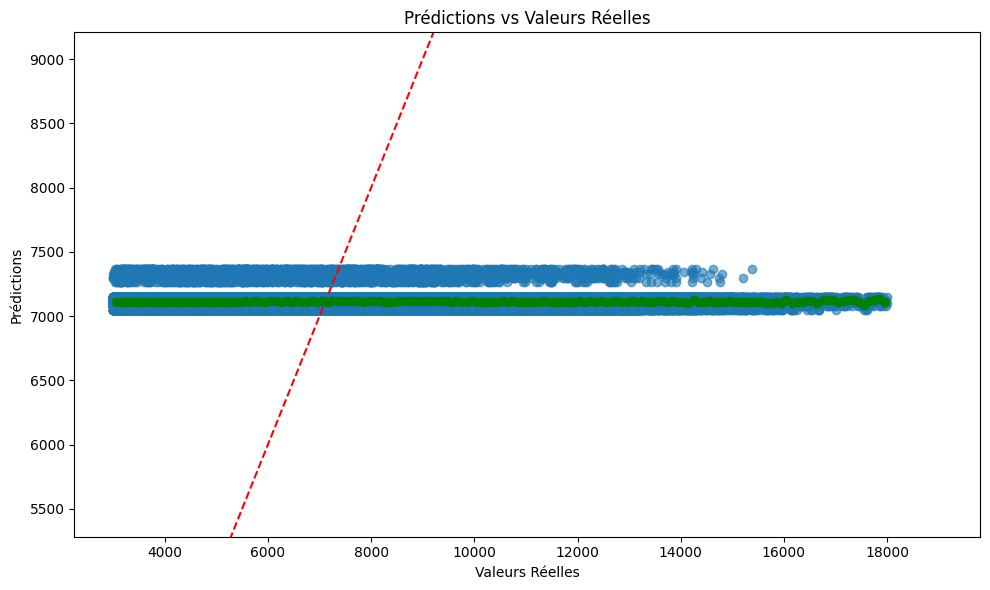

In [ ]:
y_pred_test = combined_prediction(combined_model, df_test_features)
y_test = df_test_target.collect().to_numpy().ravel()
dx = 100  # Taille des intervalles (ajuste selon l'échelle de tes données)

# Tri des données
bins = np.arange(min(y_test), max(y_test) + dx, dx)
bin_centers = bins[:-1] + dx / 2  # Centres des intervalles
mean_predictions = [np.mean(y_pred_test[(y_test >= bins[i]) & (y_test < bins[i+1])])
                    for i in range(len(bins)-1)]
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne idéale
plt.plot(bin_centers, mean_predictions, color='green', linestyle='-', marker='o',
        label="Moyenne par intervalle")
plt.title("Prédictions vs Valeurs Réelles")
plt.xlabel("Valeurs Réelles")
plt.ylabel("Prédictions")

plt.xlim(0.75*min(y_test),1.1*max(y_test))
plt.ylim(0.75*min(y_pred_test),1.25*max(y_pred_test))
plt.tight_layout()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def partial_variance_explained(y, X_physical, X_contextual):
    """
    Calcule la contribution unique et partagée des deux groupes de variables
    (physiques et contextuelles) dans l'explication de la variance de la cible y,
    en utilisant des régressions linéaires.

    Étapes réalisées :
      1. Ajustement d'un modèle avec X_physical seul et calcul de R²_physical.
      2. Ajustement d'un modèle avec X_contextual seul et calcul de R²_contextual.
      3. Ajustement d'un modèle avec X_physical et X_contextual combinés et calcul de R²_full.

    On estime ensuite :
      - La contribution unique des variables physiques :
          unique_physical = R²_full - R²_contextual
      - La contribution unique des variables contextuelles :
          unique_contextual = R²_full - R²_physical
      - La contribution partagée entre les deux groupes :
          shared = R²_physical + R²_contextual - R²_full

    Ces contributions sont ensuite exprimées en pourcentage de R²_full.

    Parameters:
    -----------
    y : array-like, shape (n_samples,)
        La variable cible (observations ou prédictions finales).
    X_physical : array-like, shape (n_samples, n_features_physical)
        Matrice des variables issues du modèle physique.
    X_contextual : array-like, shape (n_samples, n_features_contextual)
        Matrice des variables issues du modèle contextuel.

    Returns:
    --------
    result : dict
        Un dictionnaire contenant :
          - 'R2_full' : R² du modèle combiné
          - 'R2_physical' : R² du modèle avec seules les variables physiques
          - 'R2_contextual' : R² du modèle avec seules les variables contextuelles
          - 'unique_physical' : contribution unique des variables physiques
          - 'unique_contextual' : contribution unique des variables contextuelles
          - 'shared' : contribution partagée entre les deux groupes
          - 'perc_unique_physical' : contribution unique des physiques en pourcentage de R²_full
          - 'perc_unique_contextual' : contribution unique des contextuelles en pourcentage de R²_full
          - 'perc_shared' : contribution partagée en pourcentage de R²_full
    """
    # Modèle avec variables physiques seules
    model_physical = LinearRegression().fit(X_physical, y)
    y_pred_physical = model_physical.predict(X_physical)
    R2_physical = r2_score(y, y_pred_physical)

    # Modèle avec variables contextuelles seules
    model_contextual = LinearRegression().fit(X_contextual, y)
    y_pred_contextual = model_contextual.predict(X_contextual)
    R2_contextual = r2_score(y, y_pred_contextual)

    # Modèle combiné (physique + contextuel)
    X_full = np.hstack((X_physical, X_contextual))
    model_full = LinearRegression().fit(X_full, y)
    y_pred_full = model_full.predict(X_full)
    R2_full = r2_score(y, y_pred_full)

    # Calcul des contributions uniques et partagées
    unique_physical = R2_full - R2_contextual
    unique_contextual = R2_full - R2_physical
    shared = R2_physical + R2_contextual - R2_full

    if R2_full == 0:
        raise ValueError("R²_full est nul, impossible de calculer les pourcentages.")

    perc_unique_physical = (unique_physical / R2_full) * 100
    perc_unique_contextual = (unique_contextual / R2_full) * 100
    perc_shared = (shared / R2_full) * 100

    return {
        'R2_full': R2_full,
        'R2_physical': R2_physical,
        'R2_contextual': R2_contextual,
        'unique_physical': unique_physical,
        'unique_contextual': unique_contextual,
        'shared': shared,
        'perc_unique_physical': perc_unique_physical,
        'perc_unique_contextual': perc_unique_contextual,
        'perc_shared': perc_shared
    }

# Exemple d'utilisation :

# Supposons que nous disposions d'un jeu de données :
# X_physical : features physiques (ex. shape: (n_samples, 10))
# X_contextual : features contextuelles (ex. shape: (n_samples, 5))
# y : la cible (par exemple, la prédiction finale du méta-modèle ou la valeur observée)

# Pour l'exemple, créons des données simulées :
np.random.seed(42)
n_samples = 200
X_physical = np.random.randn(n_samples, 10)
X_contextual = np.random.randn(n_samples, 5)

# Supposons que la cible y soit générée par une combinaison linéaire (avec un peu de bruit)
beta_physical = np.random.randn(10)
beta_contextual = np.random.randn(5)
y = X_physical.dot(beta_physical) + X_contextual.dot(beta_contextual) + np.random.randn(n_samples) * 0.5

result = partial_variance_explained(y, X_physical, X_contextual)
print("R² total (modèle combiné) :", result['R2_full'])
print("Contribution unique physique (% de R²_full) :", result['perc_unique_physical'])
print("Contribution unique contextuelle (% de R²_full) :", result['perc_unique_contextual'])
print("Contribution partagée (% de R²_full) :", result['perc_shared'])


R² total (modèle combiné) : 0.9862792102360168
Contribution unique physique (% de R²_full) : 81.34068615712505
Contribution unique contextuelle (% de R²_full) : 30.814038953622514
Contribution partagée (% de R²_full) : -12.154725110747563
